In [23]:
# Import necessary libraries
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Import SVC for Support Vector Machine model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\mktmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mktmi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\mktmi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mktmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Step 1: Load dataset into a DataFrame (define df)
df = pd.read_csv('training_data_lowercase.csv', sep='\t', names=['label', 'text'])
df

,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...
...,...,...
34147,1,tears in rain as thais gather for late king's ...
34148,1,pyongyang university needs non-u.s. teachers a...
34149,1,philippine president duterte to visit japan ah...
34150,1,japan's abe may have won election\tbut many do...


In [7]:
# Check and clean dataset
df.dropna(subset=['text', 'label'], inplace=True)

In [8]:
# Preprocess text (lowercasing, removing punctuation, and stopwords)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    stop_words = set(stopwords.words('english'))  # Assuming English text
    return ' '.join([word for word in text.split() if word not in stop_words])

df['cleaned_text'] = df['text'].apply(preprocess_text)

In [9]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

In [11]:
# Step 4: Function to map POS tags to WordNet tags for better lemmatization
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [12]:
# Step 5: Lemmatization and POS tagging
def lemmatize_with_pos(text):
    try:
        tokens = nltk.word_tokenize(text)  # Tokenize the text
        pos_tags = nltk.pos_tag(tokens)  # Perform POS tagging
        return ' '.join([lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags])
    except Exception as e:
        print(f"Error processing text: {text}, Error: {str(e)}")
        return ""

In [14]:
# Step 6: Apply the lemmatization function to the cleaned text
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_with_pos)

In [15]:
# Step 7: Check the first few rows of the DataFrame to confirm the result
print(df.head())

   label                                               text  \
0      0  donald trump sends out embarrassing new year‚s...   
1      0  drunk bragging trump staffer started russian c...   
2      0  sheriff david clarke becomes an internet joke ...   
3      0  trump is so obsessed he even has obama‚s name ...   
4      0  pope francis just called out donald trump duri...   

                                        cleaned_text  \
0  donald trump sends embarrassing new years eve ...   
1  drunk bragging trump staffer started russian c...   
2  sheriff david clarke becomes internet joke thr...   
3  trump obsessed even obamas name coded website ...   
4  pope francis called donald trump christmas speech   

                                     lemmatized_text  
0  donald trump sends embarrass new year eve mess...  
1  drunk brag trump staffer start russian collusi...  
2  sheriff david clarke become internet joke thre...  
3    trump obsess even obamas name cod website image  
4    pope

In [19]:
# Feature Extraction using Bag of Words (or you can switch to TF-IDF below)
# Uncomment to use Bag of Words
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))  # Using bigrams as well

In [20]:
# Transform text into features
X = vectorizer.fit_transform(df['lemmatized_text'])
y = df['label']

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Initialize and train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)


SVC(kernel='linear', random_state=42)

In [25]:
# Make predictions
y_pred_svm = svm_model.predict(X_test)

In [26]:
# Evaluate the model's performance
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9063094715268628
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      3529
           1       0.89      0.92      0.91      3302

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831



In [28]:
""" # Save the SVM model and the vectorizer for future use
with open('svm_model_lemmatization.pkl', 'wb') as f:
    pickle.dump(svm_model, f) """

" # Save the SVM model and the vectorizer for future use\nwith open('svm_model_lemmatization.pkl', 'wb') as f:\n    pickle.dump(svm_model, f) "

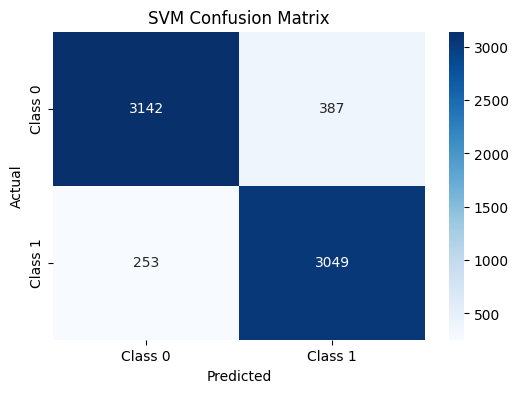

In [29]:
# Confusion Matrix to visualize performance
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM Confusion Matrix')
plt.show()